<a href="https://colab.research.google.com/github/justinolah/AA272FinalProject/blob/master/finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stanford AA 272 Final Project Code
Justin Olah, Rachel Stutz, Maryann Benny Fernandes


We used Google Drive in colab to load our files

In [56]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Georinex to load in Ephemeris files:

In [57]:
pip install georinex

Paths (Replace paths with those in your local computer):

In [58]:
EPHEM_1_PATH = 'drive/MyDrive/272FinalProject/Measurements/brdc0530.22n'
EPHEM_2_PATH = 'drive/MyDrive/272FinalProject/Measurements/brdc0670-2.22n'
GROUND_TRUTH_1_PATH = 'drive/MyDrive/272FinalProject/Measurements/ground_truths.csv'
GROUND_TRUTH_2_PATH = 'drive/MyDrive/272FinalProject/Measurements/ground_truths_mar7.csv'
PATH = "drive/MyDrive/272FinalProject/Measurements/Feb_21_2022"
PATH2 = "drive/MyDrive/272FinalProject/Measurements/Mar_7_2022"

In [59]:
import georinex as gr
ephem = gr.load(EPHEM_1_PATH,  tlim=['2022-02-22T00:00:00.000000000', '2022-02-22T00:00:00.000000000'])
ephem2 = gr.load(EPHEM_2_PATH, tlim=['2022-03-08T02:00:00.000000000', '2022-03-08T02:00:00.000000000'])

In [60]:
filenames = os.listdir(PATH)
filenames2 = ['1at_curch.txt', '2half_way_to_first_cirlce.txt', '3bottom_of_first_circle.txt', '4middle_of_first_circle.txt', '5top_of_first_circle.txt', '6quad_center_normal_torso.txt', '7oval_bottom_of_second_circle.txt', '8oval_spinning_in_circle.txt', '9oval_top_of_circle_towards_quad.txt', '10quad_above_head.txt', '11quad_in_pocket.txt']

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

Ground Truth Values:

In [62]:
# this is from https://github.com/STEMlib/lla_to_ecef by STEMlib on github
# Used to make the ground truth csv files
def lla_to_ecef(lat,lon,alt):
    """This function takes in WGS84 latitude, longitude, and altitude 
       from LLA coordinate system and converts to ECEF coordinate system

    Args:
        lat [pandas.core.series.Series]: WGS84 Latitude [degrees]
                                         Example: df.latitude
        lon [pandas.core.series.Series]: WGS84 Longitude [degrees]
                                         Example: df.longitude
        alt [pandas.core.series.Series]: WGS84 Altitude [kilometers]
                                         Example: df.altitude

    Returns:
       X [pandas.core.series.Series]: ECEF x-coordinate [meters]
       Y [pandas.core.series.Series]: ECEF y-coordinate [meters]
       Z [pandas.core.series.Series]: ECEF z-coordinate [meters]
    """    
    # convert lat and long from degrees to radians because numpy expects 
    # radians for trig functions
    deg_2_rads = np.pi/180
    lat = deg_2_rads*lat
    lon = deg_2_rads*lon    
    
    # convert altitude from kilometers to meters
    alt = 1000*alt    
    
    # convert LLA to ECEF with the following equations
    cos_lat = np.cos(lat)
    cos_lon = np.cos(lon)
    sin_lat = np.sin(lat)

    A = 6378137
    B = 6356752.31424518
    H = alt
    E1 = np.sqrt((A**2-B**2)/A**2)
    E2 = E1**2
    N = A/np.sqrt(1-E2*(sin_lat**2))

    X = (N+H)*cos_lat*cos_lon
    Y = (N+H)*cos_lat*np.sin(lon)
    Z = (N*(1-E2)+H)*sin_lat
    
    return X,Y,Z

In [63]:
# read ground truth csv files (if not using dataframes above)
ground_truths = pd.read_csv(GROUND_TRUTH_1_PATH)
ground_truths2 = pd.read_csv(GROUND_TRUTH_2_PATH)

In [64]:
def get_ground(index):
  g = ground_truths[ground_truths.index == index]
  return [g.X.tolist()[0], g.Y.tolist()[0], g.Z.tolist()[0]]

In [65]:
def get_ground2(index):
  g = ground_truths2[ground_truths2.index == index]
  return [g.X.tolist()[0], g.Y.tolist()[0], g.Z.tolist()[0]]

Load GNSS Logger Files:

In [66]:
# turns txt file into dataframe (helper for txt_to_df_cols)
# code from https://www.kaggle.com/sohier/loading-gnss-logs

def gnss_log_to_dataframes(path):
    print('Loading ' + path, flush=True)
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            if (dataline[0] != 'NMEA') and (dataline[0] != ''):
                datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            if col == 'CarrierFrequencyHz':
                continue
            results[k][col] = pd.to_numeric(results[k][col], errors='coerce')

    return results

Adds Additional Columns to dataframe:

In [67]:
# takes in .txt file, does preprocessing up to pseudorange, and returns dataframe
# cols added: WeekNumber, CorrectedRxTime, AdjustedBias, RxTimeGPS, RxTimeCW, RxTime_S, PseudorangeNanos, PseudorangeMeters

def txt_to_df_cols(filename):
    df = gnss_log_to_dataframes(filename)#pd.read_csv('drive/MyDrive/272FinalProject/fakedata.csv')#
    raw_gnss = df['Raw']
    c = 299792458
    ns_week = 6048*(10**11)
    FullBiasNanos = raw_gnss['FullBiasNanos'].tolist()
    TimeNanos = raw_gnss['TimeNanos'].tolist()
    TimeOffsetNanos = raw_gnss['TimeOffsetNanos'].tolist()
    BiasNanos = raw_gnss['BiasNanos'].tolist()
    ReceivedSvTimeNanos = raw_gnss['ReceivedSvTimeNanos'].tolist()
    WeekNumber = [math.floor(-fbn/ns_week) for fbn in FullBiasNanos]
    raw_gnss['WeekNumber'] = pd.DataFrame(WeekNumber)
    CorrectedRxTime = [a+b for a,b in zip(TimeNanos,TimeOffsetNanos)]
    raw_gnss['CorrectedRxTime'] = pd.DataFrame(CorrectedRxTime)
    AdjustedBias = [a+b for a,b in zip(FullBiasNanos,BiasNanos)]
    raw_gnss['AdjustedBias'] = pd.DataFrame(AdjustedBias)
    RxTimeGPS = [a-b for a,b in zip(CorrectedRxTime,AdjustedBias)]
    raw_gnss['RxTimeGPS'] = pd.DataFrame(RxTimeGPS)
    RxTimeCW = [a-(b*ns_week) for a,b in zip(RxTimeGPS,WeekNumber)]
    raw_gnss['RxTimeCW'] = pd.DataFrame(RxTimeCW)
    RxTime_s = [a*(10**-9) for a in RxTimeCW]
    raw_gnss['RxTime_s'] = pd.DataFrame(RxTime_s)
    PseudorangeNanos = [a-b for a,b in zip(RxTimeCW,ReceivedSvTimeNanos)]
    raw_gnss['PseudorangeNanos'] = pd.DataFrame(PseudorangeNanos)
    raw_gnss['PseudorangeMeters'] = pd.DataFrame([pr*(c*(10**-9)) for pr in PseudorangeNanos])
    return raw_gnss

Get Satellite Orbit Data from Ephemeris:

In [68]:
from math import cos, sin, sqrt, atan2

def get_sat_ECEF(ephem, tx_time):
    mu = 3.986005*(10**14)
    omega_dot_e = 7.2921151467*(10**-5)
    e = ephem['Eccentricity'].to_series()[0]
    t = tx_time * 10**-9
    a = ephem['sqrtA'].to_series()[0]**2;
    n = math.sqrt(mu/a**3) + ephem['DeltaN'].to_series()[0]
    tk = t - ephem['Toe'].to_series()[0]
    Mk = ephem['M0'].to_series()[0] + n*tk

    Ek = Mk
    prev = 1000000
    while abs(Ek - prev) > 0.0001:
        prev = Ek
        Ek = Ek - (Ek - e*sin(Ek) - Mk)/(1-e*cos(Ek))
    
    sinvk = sqrt(1-e**2)*sin(Ek) / (1-e*cos(Ek))
    cosvk = (cos(Ek) - e)/(1-e*cos(Ek))
    vk = atan2(sinvk, cosvk)

    phik = vk + ephem['omega'].to_series()[0]
    dphik = ephem['Cus'].to_series()[0]*sin(2*phik) + ephem['Cuc'].to_series()[0]*cos(2*phik)
    uk = phik + dphik
    drk = ephem['Crs'].to_series()[0]*sin(2*phik) + ephem['Crc'].to_series()[0]*cos(2*phik)
    dik = ephem['Cis'].to_series()[0]*sin(2*phik) + ephem['Cic'].to_series()[0]*cos(2*phik)
    omegak = ephem['Omega0'].to_series()[0] - omega_dot_e * t + ephem['OmegaDot'].to_series()[0]*tk
    rk = a*(1-e*cos(Ek)) + drk
    ik = ephem['Io'].to_series()[0] + ephem['IDOT'].to_series()[0]*tk + dik

    xp = rk*cos(uk)
    yp = rk*sin(uk)

    x = xp*cos(omegak) - yp*cos(ik)*sin(omegak)
    y = xp*sin(omegak) + yp*cos(ik)*cos(omegak)
    z = yp*sin(ik)

    c = 2.99792458*(10**8)
    toc = ephem['TransTime'].to_series()[0]
    af0 = ephem['SVclockBias'].to_series()[0]
    af1 = ephem['SVclockDrift'].to_series()[0]
    af2 = ephem['SVclockDriftRate'].to_series()[0]
    TGD = ephem['TGD'].to_series()[0]

    F = -4.442807633*(10**-10)
    dtr = F*e*sqrt(a)*sin(Ek)

    b = c*(af0 + af1*(t - toc) +af2*(t - toc)**2 + dtr - TGD)
    return (x,y,z,b)

Load Raw GPS Files into Dataframes:

In [69]:
dfs = []

for file in filenames:
  d = txt_to_df_cols(PATH + '/' + file)
  svs = d['Svid'].tolist()
  times = d['ReceivedSvTimeNanos'].tolist()
  X = []
  Y = []
  Z = []
  B = []
  for sv, time in zip(svs,times):
    # ephem 1 doesn't have data from SV=7 or SV=31
    if sv == 7 or sv == 31:  
      continue
    if sv < 10:
      SV = 'G0'+str(sv)
    else:
      SV = 'G'+str(sv)
    e = ephem.sel(sv=SV)
    tx_time = 0
    (x,y,z,b) = get_sat_ECEF(e,time)
    X.append(x)
    Y.append(y)
    Z.append(z)
    B.append(b)

  d['X'] = pd.DataFrame(X)
  d['Y'] = pd.DataFrame(Y)
  d['Z'] = pd.DataFrame(Z)
  d['B'] = pd.DataFrame(B)

  d = d[d.ConstellationType == 1]

  dfs.append(d)

Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/1tressider_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/2whiteplazaclawtrees.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/3oldunionarch.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/4theclaw.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/5whiteplazaroundabout.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/6circleofdeath.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/7belltower.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/8greenlibrary.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/9quadgreenlibraryinfrontofarch.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/10pigotthalltower.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/11pigotthallunderground.txt
Loading drive/MyDrive/272FinalProject/Measurements/Feb_21_2022/12p

In [70]:
dfs2 = []

for i,file in enumerate(filenames2):
  d = txt_to_df_cols(PATH2 + '/' + file)
  svs = d['Svid'].tolist()
  times = d['ReceivedSvTimeNanos'].tolist()
  X = []
  Y = []
  Z = []
  B = []
  for sv, time in zip(svs,times):
    if sv < 10:
      SV = 'G0'+str(sv)
    else:
      SV = 'G'+str(sv)
    e = ephem2.sel(sv=SV)
    tx_time = 0
    (x,y,z,b) = get_sat_ECEF(e,time)
    X.append(x)
    Y.append(y)
    Z.append(z)
    B.append(b)

  d['X'] = pd.DataFrame(X)
  d['Y'] = pd.DataFrame(Y)
  d['Z'] = pd.DataFrame(Z)
  d['B'] = pd.DataFrame(B)

  d = d[d.ConstellationType == 1]

  dfs2.append(d)

Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/1at_curch.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/2half_way_to_first_cirlce.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/3bottom_of_first_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/4middle_of_first_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/5top_of_first_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/6quad_center_normal_torso.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/7oval_bottom_of_second_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/8oval_spinning_in_circle.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/9oval_top_of_circle_towards_quad.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/10quad_above_head.txt
Loading drive/MyDrive/272FinalProject/Measurements/Mar_7_2022/11quad_in_pocket.txt


Traditional Navigation Equations:

In [71]:
from numpy.linalg import norm, pinv
# given x0, bu0, X, Y, Z, B, prange
# return x_new (xyz vector of solved position)

def get_expected_pseudoranges(x_est, bu_est, X, Y, Z, B):
    # input: position and bias estimate, satellite positions and biases
    # output: expected pseudorange measurement vector
    prs = [0 for i in range(len(X))]
    for i in range(len(X)):
        diff = [X[i] - x_est[0], Y[i] - x_est[1], Z[i] - x_est[2]]
        prs[i] = norm(diff) + bu_est - B[i]  # assume ek = 0
    return prs
    
def get_geometry_matrix(x_est, X, Y, Z):
    # input: position estimate, satellite positions
    # output: geometry matrix G
    G = np.ones((len(X), 4))
    for i in range(len(X)):
        diff = [X[i] - x_est[0], Y[i] - x_est[1], Z[i] - x_est[2]]
        G[i,0:3] = diff/norm(diff)
    return G
    
def solve_pos(x0, bu0, X, Y, Z, B, prange):
    # input: initial state estimation, satellite positions/biases/pseudoranges
    # output: solved position state vector
    # follow lecture 4 step-by-step: 1. choose initial guess already done
    G = get_geometry_matrix(x0, X, Y, Z)  # 2. compute geometry matrix G
    pr = get_expected_pseudoranges(x0, bu0, X, Y, Z, B)  # 3. compute expected pseudoranges
    pr_diff = [a - b for a, b in zip(pr, prange)]  # 4. compute difference pr - prange
    dxb = np.matmul(pinv(G), pr_diff)  # 5. compute dx, dbu
    dx = dxb[0:3]
    dbu = dxb[3]
    while norm(dx) > 1:
        x_new = x0 + dx  # 6. update x_est and bu
        bu_new = bu0 + dbu
        G = get_geometry_matrix(x_new, X, Y, Z)  # 7. repeat until convergence
        pr = get_expected_pseudoranges(x_new, bu_new, X, Y, Z, B)
        pr_diff = [a - b for a, b in zip(pr, prange)]
        dxb = np.matmul(pinv(G), pr_diff)
        dx = dxb[0:3]
        dbu = dxb[3]
        x0 = x_new
        bu0 = bu_new
    return x_new

Plotting Position Errors:

[60, 20, 29]
[401.196319386793, 17.88031080723581, 35.57608177277462]


Text(0.5, 1.0, 'Measurement Error Between True and Predicted Location')

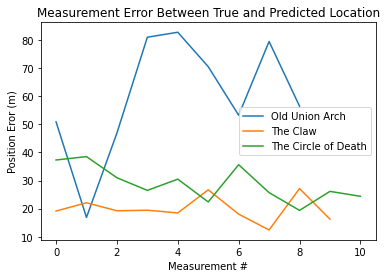

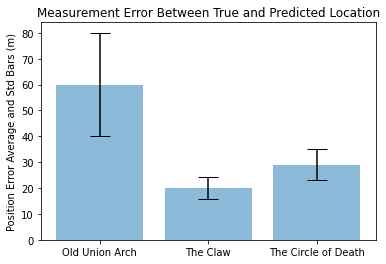

In [72]:
## Day 1 Plots
data_to_show = [2,3,5]
norms = []
variances = []
names = ["Old Union Arch", "The Claw", "The Circle of Death"]
i = 0
for index in range(18):
  if index not in data_to_show:
    continue
  ground = get_ground(index)
  unique_times = list(set(dfs[index].RxTime_s.to_list()))
  trial_time = dfs[index].RxTime_s.to_list()[int(len(unique_times)/2)]
  trial_norms = []
  for trial_time in unique_times:
    last_time_df = dfs[index].loc[dfs[index].RxTime_s == trial_time]

    X = last_time_df.X.tolist()
    Y = last_time_df.Y.tolist()
    Z = last_time_df.Z.tolist()
    B = last_time_df.B.tolist()
    prange = last_time_df.PseudorangeMeters.tolist()

    try:
      pred = solve_pos([0,0,0], 0, X,Y,Z,B,prange)
    except:
      continue
      
    n = norm(pred - ground)
    trial_norms.append(n)
  trial_average_pos_norm = np.mean(trial_norms)
  norms.append(round(trial_average_pos_norm))
  variances.append(np.var(trial_norms))
  plt.plot(trial_norms, label=names[i])
  i += 1

plt.legend()
plt.title('Measurement Error Between True and Predicted Location')
plt.xlabel('Measurement #')
plt.ylabel('Position Eror (m)')
print(norms)
print(variances)

fig, ax = plt.subplots()
ax.bar(range(3), norms, yerr=np.sqrt(variances), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(range(3))
ax.set_xticklabels(names)
ax.set_ylabel('Position Error Average and Std Bars (m)')
ax.set_title('Measurement Error Between True and Predicted Location')


[100, 86, 38, 38, 38, 37, 37]
[575.3926897629476, 1011.7967949628558, 46.90111256365879, 13.435600795128119, 54.80515559916224, 137.57122084961694, 34.248234302718366]


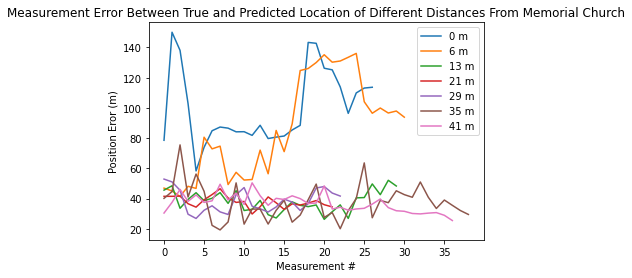

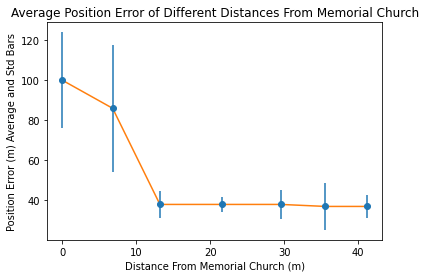

In [73]:
## MEMORIAL CHURCH Plots
to_print = [1,2,3,4,5,6,7]
distances = [0, 6.8, 13.2, 21.6, 29.6, 35.6, 41.2]
norms = []
variances = []

plt.figure()

for index in range(11):
  if (index + 1) not in to_print:
    continue
  ground = get_ground2(index)
  unique_times = list(set(dfs2[index].RxTime_s.to_list()))
  trial_norms = []
  for trial_time in unique_times:
    last_time_df = dfs2[index].loc[dfs2[index].RxTime_s == trial_time]

    X = last_time_df.X.tolist()
    Y = last_time_df.Y.tolist()
    Z = last_time_df.Z.tolist()
    B = last_time_df.B.tolist()
    prange = last_time_df.PseudorangeMeters.tolist()
    try:
      pred = solve_pos([0,0,0], 0, X,Y,Z,B,prange)
    except:
      continue
    n = norm(pred - ground)
    trial_norms.append(n)
  trial_average_pos_norm = np.mean(trial_norms)
  norms.append(round(trial_average_pos_norm))
  variances.append(np.var(trial_norms))
  plt.plot(trial_norms, label="%d m" % distances[index])

plt.legend()
plt.title('Measurement Error Between True and Predicted Location of Different Distances From Memorial Church')
plt.xlabel('Measurement #')
plt.ylabel('Position Eror (m)')

plt.figure()
plt.errorbar(distances, norms, 
             yerr = np.sqrt(variances),
             fmt ='o')
plt.plot(distances, norms)
plt.title('Average Position Error of Different Distances From Memorial Church')
plt.xlabel('Distance From Memorial Church (m)')
plt.ylabel('Position Error (m) Average and Std Bars')

print(norms)
print(variances)


[37, 38, 36]
[137.57122084961694, 61.20135547044241, 225.18103649244102]


Text(0.5, 1.0, 'Measurement Error Between True and Predicted Location with Different Phone Positions')

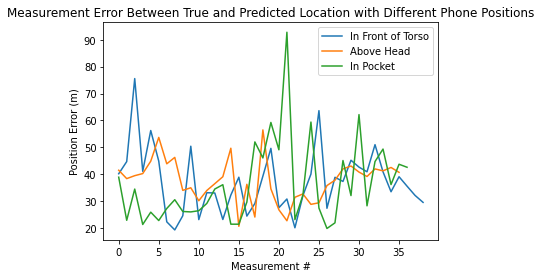

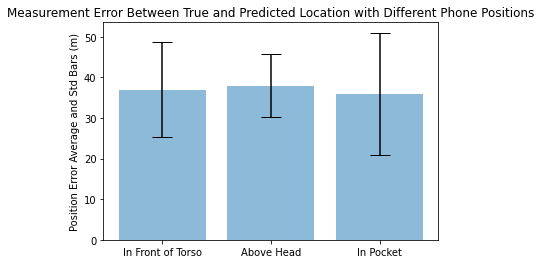

In [74]:
## Different Reciever Positions Plots
to_print = [6,10,11]
titles = ['In Front of Torso', 'Above Head', 'In Pocket']
norms = []
variances = []

plt.figure()
i = 0
for index in range(11):
  if (index + 1) not in to_print:
    continue
  ground = get_ground2(index)
  unique_times = list(set(dfs2[index].RxTime_s.to_list()))
  trial_norms = []
  for trial_time in unique_times:
    last_time_df = dfs2[index].loc[dfs2[index].RxTime_s == trial_time]

    X = last_time_df.X.tolist()
    Y = last_time_df.Y.tolist()
    Z = last_time_df.Z.tolist()
    B = last_time_df.B.tolist()
    prange = last_time_df.PseudorangeMeters.tolist()
    try:
      pred = solve_pos([0,0,0], 0, X,Y,Z,B,prange)
    except:
      continue
    n = norm(pred - ground)
    trial_norms.append(n)
  trial_average_pos_norm = np.mean(trial_norms)
  norms.append(round(trial_average_pos_norm))
  variances.append(np.var(trial_norms))
  plt.plot(trial_norms, label=titles[i])
  i += 1

plt.legend()
plt.title('Measurement Error Between True and Predicted Location with Different Phone Positions')
plt.xlabel('Measurement #')
plt.ylabel('Position Error (m)')

print(norms)
print(variances)


fig, ax = plt.subplots()
ax.bar(range(3), norms, yerr=np.sqrt(variances), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_xticks(range(3))
ax.set_xticklabels(titles)
ax.set_ylabel('Position Error Average and Std Bars (m)')
ax.set_title('Measurement Error Between True and Predicted Location with Different Phone Positions')


